In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from pylab import mpl, plt

In [2]:
#get data
csv = 'AUDCAD.pro_M15_201901020000_202107302345.csv'
url= f'data/currency/{csv}'
df = pd.read_csv(url ,parse_dates=[['<DATE>', '<TIME>']], sep = '	')
df = df.rename(columns = {'<DATE>_<TIME>' : 'Open Time', '<OPEN>' : 'Open', '<HIGH>' : 'High', '<LOW>' : 'Low',
                  '<CLOSE>' : 'Close', '<TICKVOL>' : 'TickVol', '<VOL>' : 'Vol', '<SPREAD>' : 'Spread'})
df = df[['Open Time','Open','High','Low', 'Close' ]]
df = df.set_index('Open Time')

In [3]:
data = df.pct_change()
data = data.dropna()

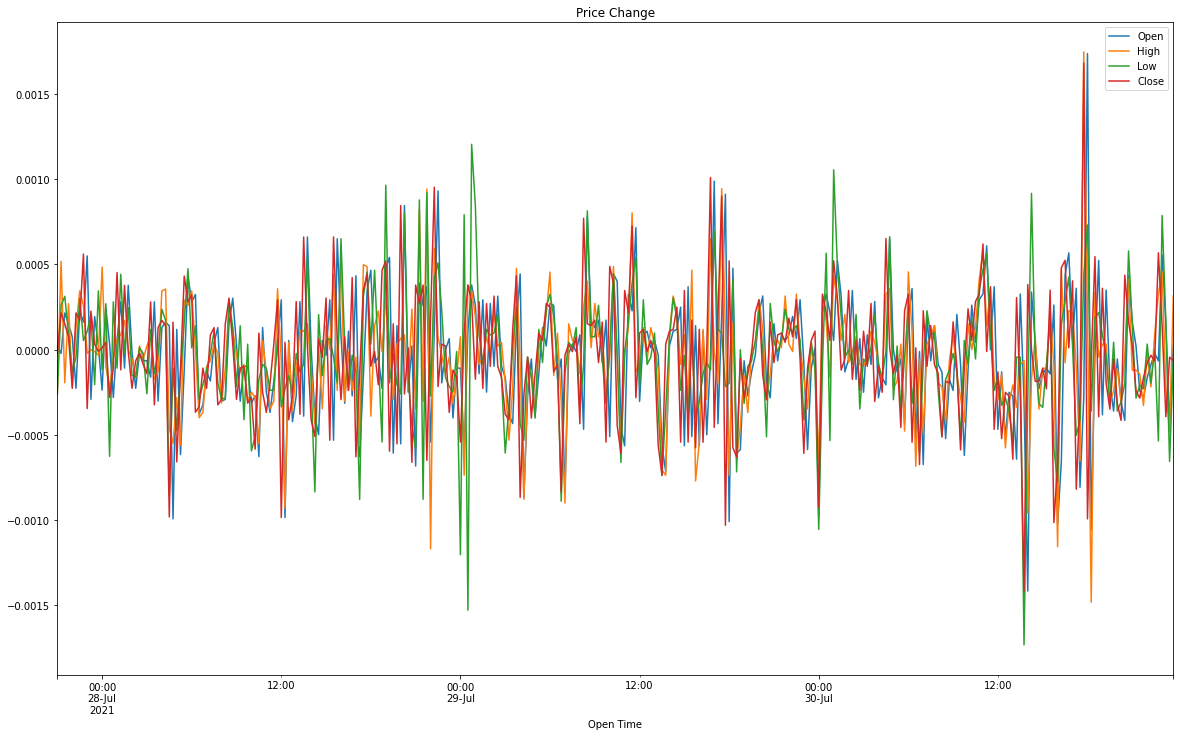

In [4]:
data[['Open','High','Low', 'Close']].iloc[-300:].plot(figsize = (20,12), title ="Price Change")
plt.show()

In [5]:
if data.isnull().values.any() == True:
    data = data.dropna() 

In [6]:
data.isnull().values.any()

False

## Test for Stationarity

<b>Null Hypothesis</b>:        Non-Stationary </p>
<b>Alternative Hypothesis</b>: Stationary

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
def test_stationarity(data_set):
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(data_set)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

In [9]:
data.isnull().values.any()

False

In [10]:
test_stationarity(data[['Open']])
test_stationarity(data[['High']])
test_stationarity(data[['Low']])
test_stationarity(data[['Close']])

Results of Dickey-Fuller Test:
Test Statistic                   -33.346145
p-value                            0.000000
#Lags Used                        61.000000
Number of Observations Used    64096.000000
Critical Value (1%)               -3.430452
Critical Value (5%)               -2.861585
Critical Value (10%)              -2.566794
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -33.315746
p-value                            0.000000
#Lags Used                        60.000000
Number of Observations Used    64097.000000
Critical Value (1%)               -3.430452
Critical Value (5%)               -2.861585
Critical Value (10%)              -2.566794
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -33.546681
p-value                            0.000000
#Lags Used                        60.000000
Number of Observations Used    64097.000000
Critical Value (1%)               -3.430452
Critical Value (5%)               -2.8615

Since the p-value is less than 0.05, We <b>reject</b> the Null hypothesis that states the timeseries is non-stationary.</p>
Hence the timeseries is <b>Stationary</b> 

## Autocorrelation

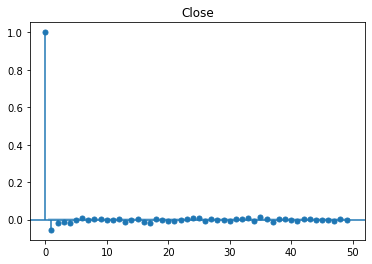

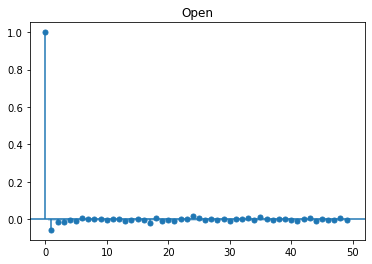

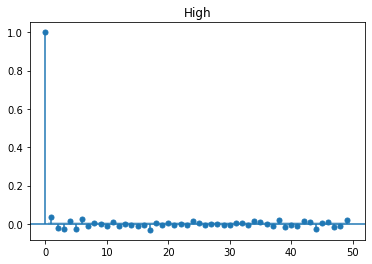

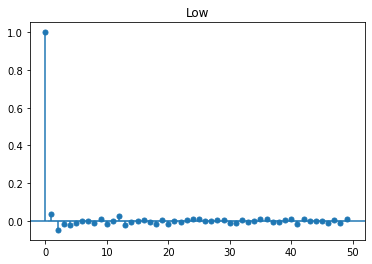

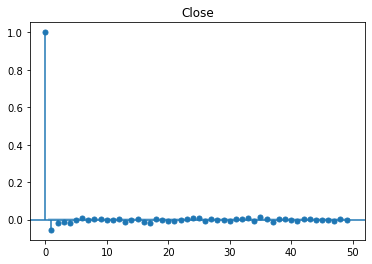

In [13]:
#import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data[['Open']], title = 'Open')
plot_pacf(data[['High']], title = 'High')
plot_pacf(data[['Low']], title = 'Low')
plot_pacf(data[['Close']], title = 'Close')

In [15]:
k_lags = ['Open','High','Low', 'Close']
lags = 3
cols = []
for i in k_lags:
    for lag in range(1, lags + 1):
        col = f'{i}lag_{lag}'
        data[col] = data[i].shift(lag)
        cols.append(col)
        
data.dropna(inplace=True)

In [16]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Openlag_1', 'Openlag_2', 'Openlag_3',
       'Highlag_1', 'Highlag_2', 'Highlag_3', 'Lowlag_1', 'Lowlag_2',
       'Lowlag_3', 'Closelag_1', 'Closelag_2', 'Closelag_3'],
      dtype='object')

In [17]:
columns = ['Open', 'High', 'Low', 'Close', 'Openlag_1', 'Openlag_2', 'Openlag_3',
       'Highlag_1', 'Highlag_2', 'Highlag_3', 'Lowlag_1', 'Lowlag_2',
       'Lowlag_3', 'Closelag_1', 'Closelag_2', 'Closelag_3']
data['direction'] = np.where(data['Close'] > 0, 1, 0)

In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop

In [20]:
optimizer = Adam(learning_rate=0.0001)

In [21]:
import random 
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed) 
    tf.random.set_seed(100)

In [22]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',input_shape=(len(columns),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
# import train_test_split libary fo splitting data to train  and validation
from sklearn.model_selection import train_test_split

train_data, test_data  = train_test_split(data ,test_size=0.2, shuffle=False)

In [24]:
%%time
model.fit(train_data[columns],
          train_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

Wall time: 2min 59s


In [25]:
model.evaluate(train_data[columns], train_data['direction'])

1604/1604 [==============================] - 4s 3ms/step - loss: 0.0625 - accuracy: 0.9842


[0.06249220296740532, 0.9841984510421753]

In [26]:
pred = np.where(model.predict(train_data[columns])> 0.5, 1, 0)
train_data['prediction'] = np.where(pred > 0, 1, -1)

C:\Users\okiki\AppData\Local\Temp/ipykernel_3792/1315356861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['prediction'] = np.where(pred > 0, 1, -1)


In [28]:
train_data['strategy'] = (train_data.prediction * train_data.Close)

C:\Users\okiki\AppData\Local\Temp/ipykernel_3792/2941589341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['strategy'] = (train_data.prediction * train_data.Close)


In [33]:
train_data[['Close','strategy']].sum()

Close        0.030447
strategy    18.121967
dtype: float64

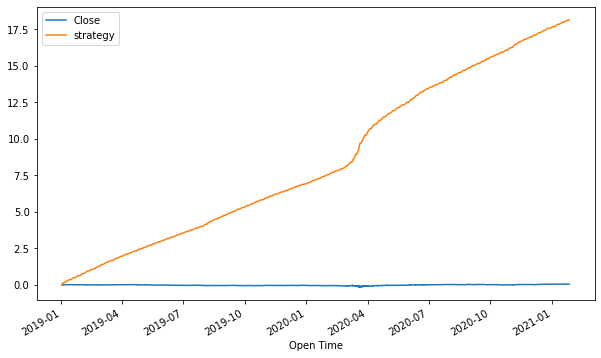

In [35]:
train_data[['Close','strategy']].cumsum().plot(figsize=(10, 6));

In [36]:
model.evaluate(test_data[columns], test_data['direction'])

401/401 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.98 - 1s 3ms/step - loss: 0.0653 - accuracy: 0.9836


[0.06526916474103928, 0.9836333990097046]

In [37]:
pred = np.where(model.predict(test_data[columns]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)


C:\Users\okiki\AppData\Local\Temp/ipykernel_3792/244799771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = np.where(pred > 0, 1, -1)


Checking the number of buys vs sells

In [38]:
test_data['prediction'].value_counts()

-1    6447
 1    6384
Name: prediction, dtype: int64

In [39]:
test_data['capital'] = 0
test_data['2021-01-26 17:45:00','capital'] = 10

C:\Users\okiki\AppData\Local\Temp/ipykernel_3792/2908121690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['capital'] = 0
C:\Users\okiki\AppData\Local\Temp/ipykernel_3792/2908121690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['2021-01-26 17:45:00','capital'] = 10


In [40]:
test_data.loc[:,'strategy'] = (test_data.prediction * test_data.Close)
test_data.loc[:,'capital'] = test_data.capital + test_data.strategy * 10
test_data[['Close','strategy']].sum()

c:\users\okiki\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\okiki\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Close      -0.068442
strategy    3.795418
dtype: float64

In [54]:
test_data[['capital']].sum()

capital    37.954184
dtype: float64

In [56]:
pct = test_data[['capital']].pct_change()
pct = pct.dropna()

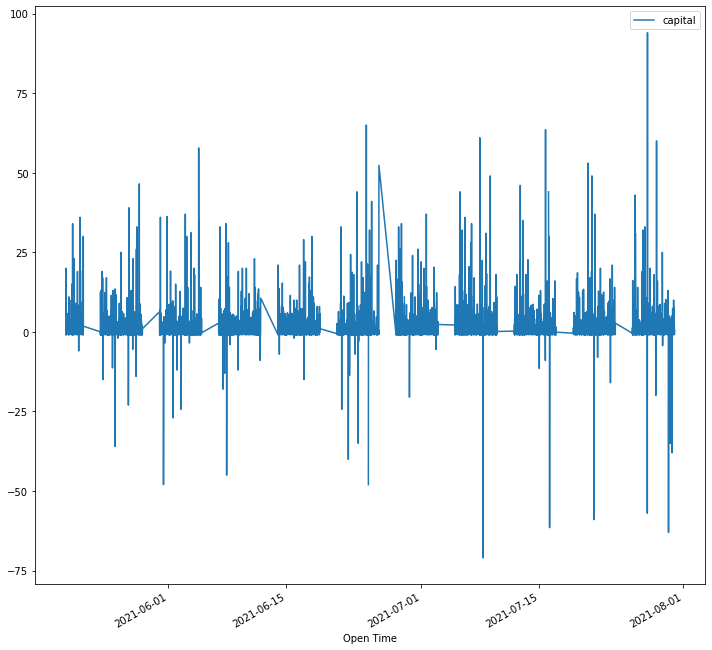

In [59]:
pct.iloc[-5000:].plot(figsize=(12, 11.8));

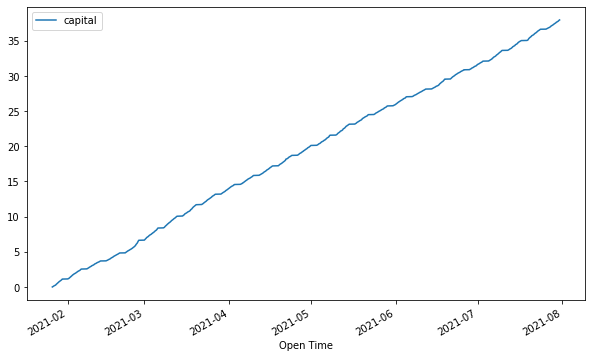

In [45]:
test_data[['capital']].cumsum().plot(figsize=(10, 6));

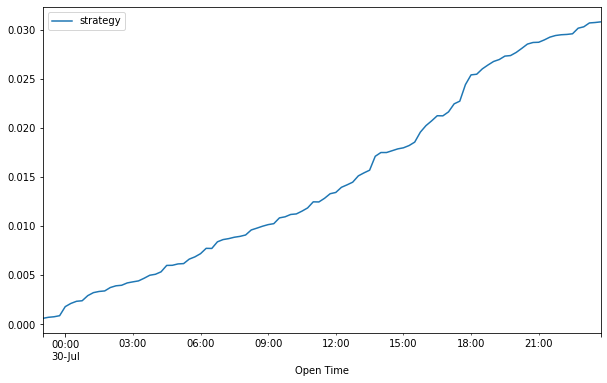

In [44]:
test_data[['strategy']].iloc[-100:].cumsum().plot(figsize=(10, 6));
#print(data.iloc[3,'Close'])